In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pprint import pprint

from utils import merge_kernel_time, get_fc_flops

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
pd.set_option('display.max_rows', 80)
%matplotlib inline

In [2]:
path = "../data/linear/hello.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(32384, 72)


,Params,Inputs,Precision,Bias,Input Size,Output Size,Kernel Name,Context,Stream,Block Size,...,SM Busy (%),SM Frequency (cycle/usecond),Shared Memory Configuration Size (Kbyte),Static Shared Memory Per Block (byte/block),Theoretical Active Warps per SM (warp),Theoretical Occupancy (%),Threads (thread),Warp Cycles Per Executed Instruction (cycle),Warp Cycles Per Issued Instruction (cycle),Latency (ms)
0,1.161.0.1.1,1,161,0,1,1,"std::enable_if<!T7, void>::type internal::gemv...",1,7,"(32, 4, 1)",...,4.43,1150.0,16.38,0.0,12.0,18.75,128.0,20.52,17.92,0.109056
1,1.161.0.1.2,1,161,0,1,2,"void gemmk1_kernel<int, float, (int)256, (int)...",1,7,"(256, 1, 1)",...,5.42,1230.0,32.77,1020.0,64.0,100.00,256.0,35.35,29.28,0.109568
2,1.161.0.1.4,1,161,0,1,4,"void gemmk1_kernel<int, float, (int)256, (int)...",1,7,"(256, 1, 1)",...,5.42,1210.0,32.77,1020.0,64.0,100.00,256.0,35.53,29.43,0.108032
3,1.161.0.1.8,1,161,0,1,8,"void gemmk1_kernel<int, float, (int)256, (int)...",1,7,"(256, 1, 1)",...,5.20,1210.0,32.77,1020.0,64.0,100.00,256.0,35.41,29.32,0.108032
4,1.161.0.1.12,1,161,0,1,12,"void gemmk1_kernel<int, float, (int)256, (int)...",1,7,"(256, 1, 1)",...,5.40,1260.0,32.77,1020.0,64.0,100.00,256.0,35.34,29.26,0.109568


In [5]:
df['kFLOPs'] = df.apply(get_fc_flops, axis=1)
df = merge_kernel_time(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29400 entries, 0 to 29399
Data columns (total 70 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Params                                           29400 non-null  object 
 1   Inputs                                           29400 non-null  float64
 2   Precision                                        29400 non-null  float64
 3   Bias                                             29400 non-null  float64
 4   Input Size                                       29400 non-null  float64
 5   Output Size                                      29400 non-null  float64
 6   Context                                          29400 non-null  float64
 7   Stream                                           29400 non-null  float64
 8   Device                                           29400 non-null  float64
 9   CC                          

In [10]:
to_drop = {"Params", "Kernel Name", "Context", "Stream", "Block Size", "Grid Size", "Device", "CC", "Function Cache Configuration"} # Kernels Launched
y_cols = {"Latency (ms)", "Duration (usecond)"}
# y_cols = {"Duration (usecond)"}
columns = set(df.columns)
X_cols = sorted(columns - to_drop - y_cols)

# X_cols = sorted(["Inputs", "Input Size", "Output Size", "Bias", "kFLOPs"])

# for col in to_drop:
#     print(df[col].unique())

# for col in X_cols:
#     print(df[col][0])

In [11]:
X, y = df[list(X_cols)], df['Latency (ms)'] # df['Duration (usecond)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0) # TODO: change!
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_train, y_train], axis=1)

In [23]:
# train_df.head()
# X_train.head()
# y_train.head()

In [24]:
# train_df.info()
# X_train.info()

In [25]:
# train_df.describe()

0.09730767403756466


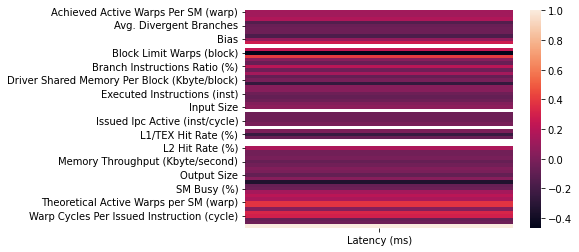

In [12]:
sns.heatmap(train_df.corr()[['Latency (ms)']])

print(df['Duration (usecond)'].corr(df['Latency (ms)']))

# for col in X_cols:
#     print(f"{col}: {df[col].corr(df['Latency (ms)'])}")

In [50]:
# train_df.hist(figsize=(16, 8))

In [13]:
# Example using StandardScaler
scaler = StandardScaler()
X_train = sm.add_constant(scaler.fit_transform(X_train))
X_test = sm.add_constant(scaler.transform(X_test))
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Latency (ms)   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     274.4
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:16:16   Log-Likelihood:                 69672.
No. Observations:               14700   AIC:                        -1.392e+05
Df Residuals:                   14644   BIC:                        -1.388e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0974   1.75e-05   5572.357      0.0

Train r2: 0.5075319982430522
Train MSE: 4.4744796622485875e-06
Validation r2: 0.5009960259184534
Validation MSE: 4.678391632799515e-06
(14700,) (14700,)


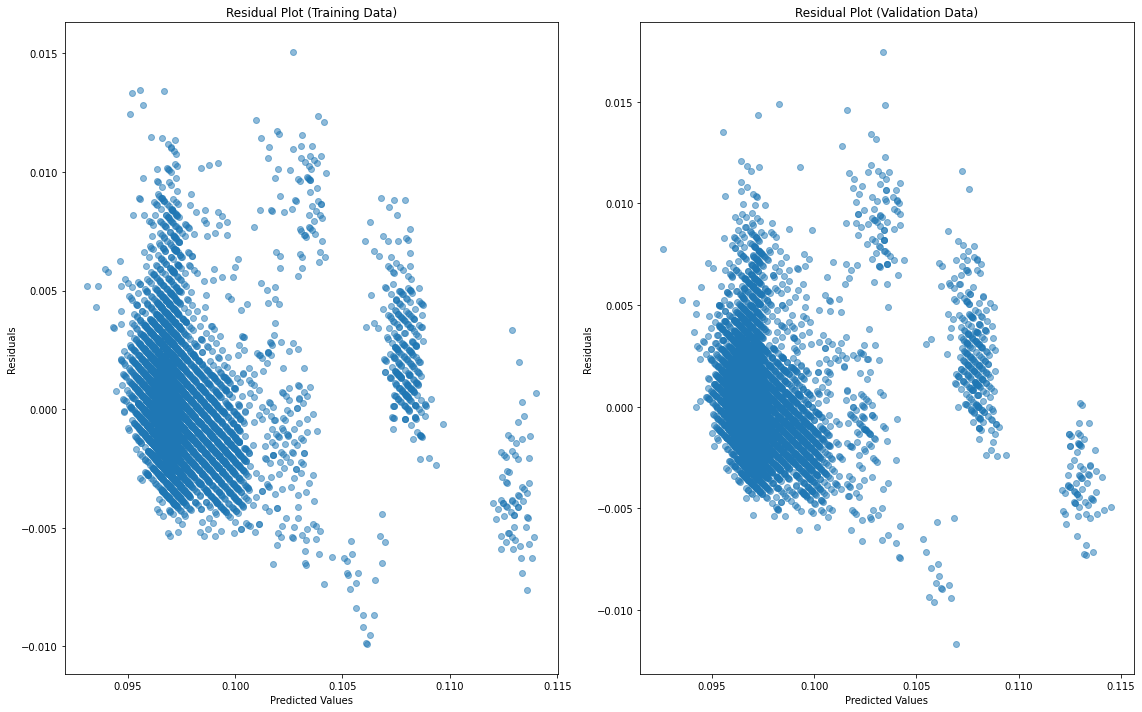

In [15]:
y_pred = model.predict(X_train)
y_pred_val = model.predict(X_test)

print('Train r2:', r2_score(y_train, y_pred))
print('Train MSE:', mean_squared_error(y_train, y_pred))

print('Validation r2:', r2_score(y_test, y_pred_val))
print('Validation MSE:', mean_squared_error(y_test, y_pred_val))

residuals_train = y_train - y_pred
residuals_val = y_test - y_pred_val

print(y_pred.shape, residuals_train.shape)

# Plot residual graph for training data
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals_train, alpha=0.5)
plt.title('Residual Plot (Training Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Plot residual graph for validation data
plt.subplot(1, 2, 2)
plt.scatter(y_pred_val, residuals_val, alpha=0.5)
plt.title('Residual Plot (Validation Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Latency')

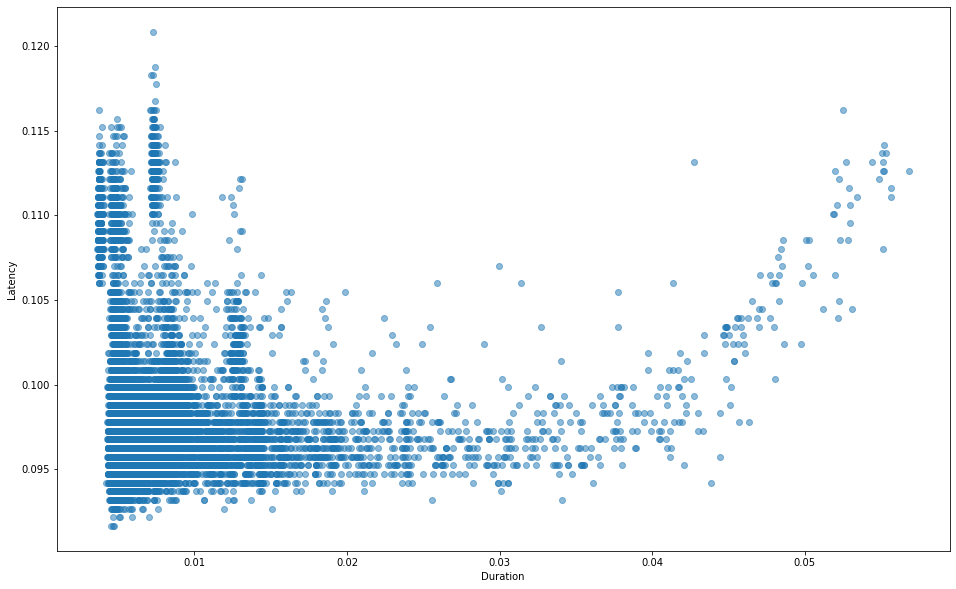

In [17]:
latency, runtime = df['Latency (ms)'], df['Duration (usecond)'] / 1000.0
plt.figure(figsize=(16, 10))
plt.scatter(runtime, latency, alpha=0.5)
plt.xlabel('Duration')
plt.ylabel('Latency')

Text(0, 0.5, 'Latency')

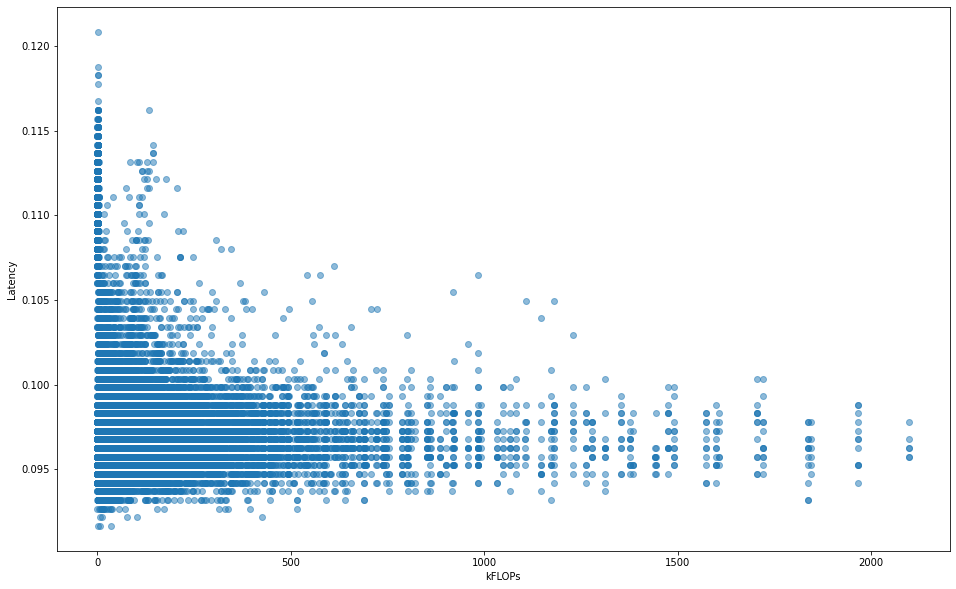

In [14]:
latency, flops = df['Latency (ms)'], df['kFLOPs']
plt.figure(figsize=(16, 10))
plt.scatter(flops, latency, alpha=0.5)
plt.xlabel('kFLOPs')
plt.ylabel('Latency')

Text(0, 0.5, 'Duration')

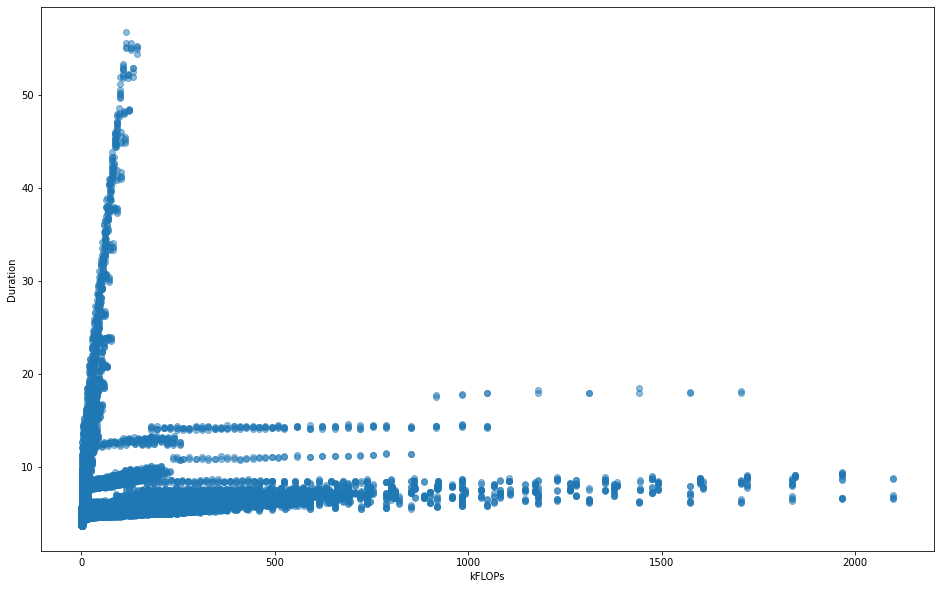

In [15]:
runtime, flops = df['Duration (usecond)'], df['kFLOPs']
plt.figure(figsize=(16, 10))
plt.scatter(flops, runtime, alpha=0.5)
plt.xlabel('kFLOPs')
plt.ylabel('Duration')

In [82]:
print(df['Latency (ms)'].max())

0.2355200052261352
